<a href="https://colab.research.google.com/github/nitinsaimajji/voice1/blob/main/weekly_code/Week_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
pip install python_speech_features


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [147]:
!git clone https://github.com/nitinsaimajji/voice1.git

fatal: destination path 'voice1' already exists and is not an empty directory.


In [148]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **A1**

In [151]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from pydub import AudioSegment
from python_speech_features import mfcc
from time import time
import IPython.display as ipd
import librosa
import librosa.display

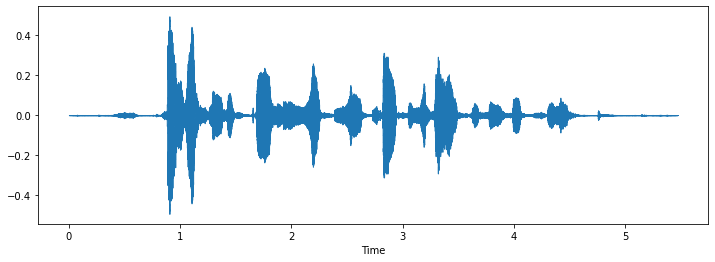

In [153]:
filename = '/content/voice1/dataset1/female-sample-000106.wav'
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.wave(data,sr=sample_rate)
ipd.Audio(filename)

In [154]:
df = pd.read_csv('/content/voice1/wav_check.csv')
df.head()

,filename,gender
0,male-sample-000008.wav,male
1,male-sample-000014.wav,male
2,male-sample-000019.wav,male
3,male-sample-000020.wav,male
4,male-sample-000023.wav,male


In [155]:
TRAIN_PATH = '/content/voice/cv-valid-train/'
!pip install wavefile
!pip install helpers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [206]:
max_pad_len = 174

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        
        if mfccs.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
            
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs


In [207]:

import os

fulldatasetpath = '/content/voice1/dataset1'

df = pd.read_csv('/content/voice1/wav_check.csv')


features = []


for index, row in df.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath)+'/',str(row["filename"]))
    
    class_label = row["gender"]
    data = extract_features(file_name)
    
    features.append([data, class_label])


featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

Finished feature extraction from  200  files


In [208]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

**CNN ARCHITECTURE**

In [209]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [210]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [211]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 19, 86, 16)       0         
 g2D)                                                            
                                                                 
 dropout_79 (Dropout)        (None, 19, 86, 16)        0         
                                                                 
 conv2d_83 (Conv2D)          (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_83 (MaxPoolin  (None, 9, 42, 32)        0         
 g2D)                                                            
                                                                 
 dropout_80 (Dropout)        (None, 9, 42, 32)       

In [212]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history=model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/72
1/1 [==============================] - ETA: 0s - loss: 5.2796 - accuracy: 0.4750
Epoch 1: val_loss improved from inf to 5.65987, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 4s 4s/step - loss: 5.2796 - accuracy: 0.4750 - val_loss: 5.6599 - val_accuracy: 0.4750
Epoch 2/72
1/1 [==============================] - ETA: 0s - loss: 10.1226 - accuracy: 0.5063
Epoch 2: val_loss improved from 5.65987 to 5.03961, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 1s 849ms/step - loss: 10.1226 - accuracy: 0.5063 - val_loss: 5.0396 - val_accuracy: 0.4750
Epoch 3/72
1/1 [==============================] - ETA: 0s - loss: 8.9848 - accuracy: 0.5063
Epoch 3: val_loss improved from 5.03961 to 2.55877, saving model to saved_models/weights.best.basic_cnn.hdf5
1/1 [==============================] - 1s 804ms/step - loss: 8.9848 - accuracy: 0.5063 - val_loss: 2.5588 - val_accuracy: 0.4750
Epoch 4/72
1/1 

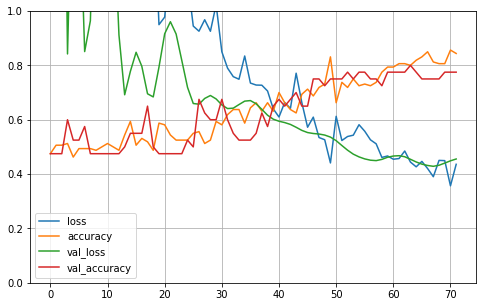

1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.
2. If the validation loss is greater than the training loss,The model is overfitting.
3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit


In [213]:
import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
print('1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.')
print('2. If the validation loss is greater than the training loss,The model is overfitting.')
print('3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit')

In [214]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1]*100,"%")

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1]*100,"%")

Training Accuracy:  86.2500011920929 %
Testing Accuracy:  77.49999761581421 %


In [215]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict(prediction_feature)
    predicted_class = le.inverse_transform(np.argmax(predicted_vector, axis=-1)) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = predicted_vector
    for i in range(len(predicted_proba_vector[0])): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba_vector[0][i]*100,'.32f'),"%")

In [216]:
filename = '/content/voice1/dataset/female-sample-000005.wav' 
print_prediction(filename) 

1/1 [==============================] - 0s 112ms/step
The predicted class is: female 

female 		 :  92.56220459938049316406250000000000 %
male 		 :  7.43779614567756652832031250000000 %


# A2

In [252]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [253]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Add a new layer to extract the feature map from the last convolutional layer
model.add(Conv2D(filters=128, kernel_size=2, activation='relu', name='feature_extraction_layer'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))


In [270]:
# Create a new model that includes all the layers up to the feature_extraction_layer
from keras.models import Model
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('feature_extraction_layer').output)

# Use the feature extractor to extract the feature maps from the last convolutional layer
train_feature_maps = feature_extractor.predict(x_train)
test_feature_maps = feature_extractor.predict(x_test)

# Flatten the feature maps to create feature matrices for both the training and test sets
train_feature_matrix = train_feature_maps.reshape(train_feature_maps.shape[0], -1)
test_feature_matrix = test_feature_maps.reshape(test_feature_maps.shape[0], -1)



2/2 [==============================] - 0s 31ms/step


KNN

In [271]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_feature_matrix, y_train)

# Predict the labels for the test set
y_pred = knn.predict(test_feature_matrix)

# Evaluate the performance of the model using metrics such as accuracy, precision, recall, etc.
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))
print("Recall:", metrics.recall_score(y_test, y_pred, average='weighted'))

Accuracy: 0.725
Precision: 0.7248737373737374
Recall: 0.725


Classifiers :  KNN,SVM,Naive Bayes,Deision Tree

SVM

In [273]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm = SVC(kernel='linear', C=1, gamma='auto')
# y_train = np.argmax(y_train, axis=1)
# y_test = np.argmax(y_test, axis=1)

svm.fit(train_feature_matrix, y_train)


y_pred = svm.predict(test_feature_matrix)

# Evaluate the performance of the model using metrics such as accuracy, precision, recall, etc.
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))
print("Recall:", metrics.recall_score(y_test, y_pred, average='weighted'))


Accuracy: 0.75
Precision: 0.75
Recall: 0.75


Naive bayes

In [274]:
from sklearn.naive_bayes import MultinomialNB


nb = MultinomialNB()
nb.fit(train_feature_matrix, y_train)


y_pred = nb.predict(test_feature_matrix)

# Evaluate the performance of the model using metrics such as accuracy, precision, recall, etc.
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))
print("Recall:", metrics.recall_score(y_test, y_pred, average='weighted'))


Accuracy: 0.675
Precision: 0.6814393939393939
Recall: 0.675


Decision Tree

In [275]:
from sklearn.tree import DecisionTreeClassifier


dt = DecisionTreeClassifier()
dt.fit(train_feature_matrix, y_train)

y_pred = dt.predict(test_feature_matrix)

# Evaluate the performance of the model using metrics such as accuracy, precision, recall, etc.
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))
print("Recall:", metrics.recall_score(y_test, y_pred, average='weighted'))


Accuracy: 0.75
Precision: 0.75
Recall: 0.75


Reggressor : Linear Regression, KNN regressor , 

Linear Regression

we're using the scikit-learn LinearRegression class to train a linear regression model. We fit the model to the extracted feature vectors from the training data using the fit method.

Next, we use the trained linear regression model to predict the labels for the test feature vectors using the predict method. We compute the mean squared error (MSE) of the linear regression model on the test data using the scikit-learn mean_squared_error function.

In [281]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train_feature_matrix, y_train)

y_pred = lr.predict(test_feature_matrix)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error: {:.2f}".format(mse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R-squared: {:.2f}".format(r2))


Mean Squared Error: 0.16
Mean Absolute Error: 0.46
R-squared: -0.45


KNN Regressor

In [282]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(train_feature_matrix, y_train)

y_pred = knn.predict(test_feature_matrix)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error: {:.2f}".format(mse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R-squared: {:.2f}".format(r2))


Mean Squared Error: 0.22
Mean Absolute Error: 0.46
R-squared: -0.45


Random Forest Regressor


In [283]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the random forest regressor with 100 trees
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the random forest regressor using the feature map from the last convolutional layer as input and the corresponding target values
rf.fit(train_feature_matrix, y_train)

# Predict the target values for the test feature map using the trained random forest regressor
y_pred = rf.predict(test_feature_matrix)

# Evaluate the performance of the random forest regressor using metrics such as mean squared error, mean absolute error, etc.
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)


print("Mean Squared Error: {:.2f}".format(mse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R-squared: {:.2f}".format(r2))


Mean Squared Error: 0.13
Mean Absolute Error: 0.30
R-squared: 0.48


Metrics such as mean squared error (MSE) and mean absolute error (MAE) are commonly used to evaluate the performance of regression models, including the random forest regressor.

The main reason for using these metrics is that they provide a quantitative measure of how well the model is able to predict the target variable. MSE, for example, measures the average squared difference between the predicted and actual values, while MAE measures the average absolute difference between the predicted and actual values.
Classification metrics can't handle a mix of binary and continuous targets